# 机器学习练习-决策树

1．分类决策树模型是表示基于特征对实例进行分类的树形结构。决策树可以转换成一个**if-then**规则的集合，也可以看作是定义在特征空间划分上的类的条件概率分布。

2．决策树学习旨在构建一个与训练数据拟合很好，并且复杂度小的决策树。因为从可能的决策树中直接选取最优决策树是NP完全问题。现实中采用启发式方法学习次优的决策树。

决策树学习算法包括3部分：特征选择、树的生成和树的剪枝。常用的算法有ID3、
C4.5和CART。

3．特征选择的目的在于选取对训练数据能够分类的特征。特征选择的关键是其准则。常用的准则如下：

（1）样本集合$D$对特征$A$的信息增益（ID3）


$$g(D, A)=H(D)-H(D|A)$$

$$H(D)=-\sum_{k=1}^{K} \frac{\left|C_{k}\right|}{|D|} \log _{2} \frac{\left|C_{k}\right|}{|D|}$$

$$H(D | A)=\sum_{i=1}^{n} \frac{\left|D_{i}\right|}{|D|} H\left(D_{i}\right)$$

其中，$H(D)$是数据集$D$的熵，$H(D_i)$是数据集$D_i$的熵，$H(D|A)$是数据集$D$对特征$A$的条件熵。	$D_i$是$D$中特征$A$取第$i$个值的样本子集，$C_k$是$D$中属于第$k$类的样本子集。$n$是特征$A$取 值的个数，$K$是类的个数。

（2）样本集合$D$对特征$A$的信息增益比（C4.5）


$$g_{R}(D, A)=\frac{g(D, A)}{H(D)}$$


其中，$g(D,A)$是信息增益，$H(D)$是数据集$D$的熵。

（3）样本集合$D$的基尼指数（CART）

$$\operatorname{Gini}(D)=1-\sum_{k=1}^{K}\left(\frac{\left|C_{k}\right|}{|D|}\right)^{2}$$

特征$A$条件下集合$D$的基尼指数：

 $$\operatorname{Gini}(D, A)=\frac{\left|D_{1}\right|}{|D|} \operatorname{Gini}\left(D_{1}\right)+\frac{\left|D_{2}\right|}{|D|} \operatorname{Gini}\left(D_{2}\right)$$
 
4．决策树的生成。通常使用信息增益最大、信息增益比最大或基尼指数最小作为特征选择的准则。决策树的生成往往通过计算信息增益或其他指标，从根结点开始，递归地产生决策树。这相当于用信息增益或其他准则不断地选取局部最优的特征，或将训练集分割为能够基本正确分类的子集。

5．决策树的剪枝。由于生成的决策树存在过拟合问题，需要对它进行剪枝，以简化学到的决策树。决策树的剪枝，往往从已生成的树上剪掉一些叶结点或叶结点以上的子树，并将其父结点或根结点作为新的叶结点，从而简化生成的决策树。


In [162]:
import numpy as np
import pandas as pd
import math
from math import log

### 创建数据

In [163]:
def create_data():
    datasets = [['青年', '否', '否', '一般', '否'],
               ['青年', '否', '否', '好', '否'],
               ['青年', '是', '否', '好', '是'],
               ['青年', '是', '是', '一般', '是'],
               ['青年', '否', '否', '一般', '否'],
               ['中年', '否', '否', '一般', '否'],
               ['中年', '否', '否', '好', '否'],
               ['中年', '是', '是', '好', '是'],
               ['中年', '否', '是', '非常好', '是'],
               ['中年', '否', '是', '非常好', '是'],
               ['老年', '否', '是', '非常好', '是'],
               ['老年', '否', '是', '好', '是'],
               ['老年', '是', '否', '好', '是'],
               ['老年', '是', '否', '非常好', '是'],
               ['老年', '否', '否', '一般', '否'],
               ]
    labels = [u'年龄', u'有工作', u'有自己的房子', u'信贷情况', u'类别']
    # 返回数据集和每个维度的名称
    return datasets, labels

In [164]:
datasets, labels = create_data()

In [165]:
train_data = pd.DataFrame(datasets, columns=labels)

In [166]:
train_data

,年龄,有工作,有自己的房子,信贷情况,类别
0,青年,否,否,一般,否
1,青年,否,否,好,否
2,青年,是,否,好,是
3,青年,是,是,一般,是
4,青年,否,否,一般,否
5,中年,否,否,一般,否
6,中年,否,否,好,否
7,中年,是,是,好,是
8,中年,否,是,非常好,是
9,中年,否,是,非常好,是


### 熵

In [167]:
# 计算给定数据集的熵（信息熵）
def calc_ent(datasets):
    # 计算数据集的长度
    data_length = len(datasets)
    # 统计数据集中每个类别的出现次数
    label_count = {}
    for i in range(data_length):
        # 获取每个样本的标签
        label = datasets[i][-1]
        # 如果该类别不在label_count中，则添加到label_count中
        if label not in label_count:
            label_count[label] = 0
        # 统计该类别的出现次数
        label_count[label] += 1
    # 计算熵
    ent = -sum([(p / data_length) * log(p / data_length, 2)
                for p in label_count.values()])
    return ent

### 条件熵

In [168]:
# 计算给定数据集在指定特征上的条件熵
def cond_ent(datasets, axis=0):
    # 计算数据集的长度
    data_length = len(datasets)
    # 使用字典feature_sets存储在指定特征上的不同取值对应的样本集合
    feature_sets = {}
    for i in range(data_length):
        # 获取每个样本在指定特征上的取值
        feature = datasets[i][axis]
        # 如果该取值不在feature_sets中，则添加到feature_sets中
        if feature not in feature_sets:
            feature_sets[feature] = []
        # 将该样本添加到对应取值的样本集合中
        feature_sets[feature].append(datasets[i])
    # 计算条件熵
    cond_ent = sum([(len(p) / data_length) * calc_ent(p)
                    for p in feature_sets.values()])
    return cond_ent

In [169]:
calc_ent(datasets)

0.9709505944546686

### 信息增益

In [170]:
# 计算信息增益
def info_gain(ent, cond_ent):
    # 信息增益等于熵减去条件熵
    return ent - cond_ent

In [171]:
# 使用信息增益选择最佳特征作为根节点特征进行决策树的训练
def info_gain_train(datasets):
    # 计算特征的数量
    count = len(datasets[0]) - 1
    # 计算整个数据集的熵
    ent = calc_ent(datasets)
    # 存储每个特征的信息增益
    best_feature = []
    for c in range(count):
        # 计算每个特征的条件熵
        c_info_gain = info_gain(ent, cond_ent(datasets, axis=c))
        # 将特征及其对应的信息增益存入best_feature列表中
        best_feature.append((c, c_info_gain))
        # 输出每个特征的信息增益
        print('特征({}) 的信息增益为： {:.3f}'.format(labels[c], c_info_gain))
    # 找到信息增益最大的特征
    best_ = max(best_feature, key=lambda x: x[-1])
    # 返回信息增益最大的特征作为根节点特征
    return '特征({})的信息增益最大，选择为根节点特征'.format(labels[best_[0]])

In [172]:
info_gain_train(np.array(datasets))

特征(年龄) 的信息增益为： 0.083
特征(有工作) 的信息增益为： 0.324
特征(有自己的房子) 的信息增益为： 0.420
特征(信贷情况) 的信息增益为： 0.363


'特征(有自己的房子)的信息增益最大，选择为根节点特征'

### 利用ID3算法生成决策树

In [173]:
# 定义节点类 二叉树
class Node:
    def __init__(self, root=True, label=None, feature_name=None, feature=None):
        self.root = root
        self.label = label
        self.feature_name = feature_name
        self.feature = feature
        self.tree = {}
        self.result = {
            'label:': self.label,
            'feature': self.feature,
            'tree': self.tree
        }

    def __repr__(self):
        return '{}'.format(self.result)

    def add_node(self, val, node):
        self.tree[val] = node

    def predict(self, features):
        if self.root is True:
            return self.label
        return self.tree[features[self.feature]].predict(features)


class DTree:
    def __init__(self, epsilon=0.1):
        self.epsilon = epsilon
        self._tree = {}

    # 熵
    @staticmethod
    def calc_ent(datasets):
        data_length = len(datasets)
        label_count = {}
        for i in range(data_length):
            label = datasets[i][-1]
            if label not in label_count:
                label_count[label] = 0
            label_count[label] += 1
        ent = -sum([(p / data_length) * log(p / data_length, 2)
                    for p in label_count.values()])
        return ent

    # 经验条件熵
    def cond_ent(self, datasets, axis=0):
        data_length = len(datasets)
        feature_sets = {}
        for i in range(data_length):
            feature = datasets[i][axis]
            if feature not in feature_sets:
                feature_sets[feature] = []
            feature_sets[feature].append(datasets[i])
        cond_ent = sum([(len(p) / data_length) * self.calc_ent(p)
                        for p in feature_sets.values()])
        return cond_ent

    # 信息增益
    @staticmethod
    def info_gain(ent, cond_ent):
        return ent - cond_ent

    def info_gain_train(self, datasets):
        count = len(datasets[0]) - 1
        ent = self.calc_ent(datasets)
        best_feature = []
        for c in range(count):
            c_info_gain = self.info_gain(ent, self.cond_ent(datasets, axis=c))
            best_feature.append((c, c_info_gain))
        # 比较大小
        best_ = max(best_feature, key=lambda x: x[-1])
        return best_

    def train(self, train_data):
        """
        input:数据集D(DataFrame格式)，特征集A，阈值eta
        output:决策树T
        """
        _, y_train, features = train_data.iloc[:, :
                                               -1], train_data.iloc[:,
                                                                    -1], train_data.columns[:
                                                                                            -1]
        # 1,若D中实例属于同一类Ck，则T为单节点树，并将类Ck作为结点的类标记，返回T
        if len(y_train.value_counts()) == 1:
            return Node(root=True, label=y_train.iloc[0])

        # 2, 若A为空，则T为单节点树，将D中实例树最大的类Ck作为该节点的类标记，返回T
        if len(features) == 0:
            return Node(
                root=True,
                label=y_train.value_counts().sort_values(
                    ascending=False).index[0])

        # 3,计算最大信息增益 同5.1,Ag为信息增益最大的特征
        max_feature, max_info_gain = self.info_gain_train(np.array(train_data))
        max_feature_name = features[max_feature]

        # 4,Ag的信息增益小于阈值eta,则置T为单节点树，并将D中是实例数最大的类Ck作为该节点的类标记，返回T
        if max_info_gain < self.epsilon:
            return Node(
                root=True,
                label=y_train.value_counts().sort_values(
                    ascending=False).index[0])

        # 5,构建Ag子集
        node_tree = Node(
            root=False, feature_name=max_feature_name, feature=max_feature)

        feature_list = train_data[max_feature_name].value_counts().index
        for f in feature_list:
            sub_train_df = train_data.loc[train_data[max_feature_name] ==
                                          f].drop([max_feature_name], axis=1)

            # 6, 递归生成树
            sub_tree = self.train(sub_train_df)
            node_tree.add_node(f, sub_tree)

        # pprint.pprint(node_tree.tree)
        return node_tree

    def fit(self, train_data):
        self._tree = self.train(train_data)
        return self._tree

    def predict(self, X_test):
        return self._tree.predict(X_test)

In [174]:
datasets, labels = create_data()
data_df = pd.DataFrame(datasets, columns=labels)
dt = DTree()
tree = dt.fit(data_df)

In [175]:
tree

{'label:': None, 'feature': 2, 'tree': {'否': {'label:': None, 'feature': 1, 'tree': {'否': {'label:': '否', 'feature': None, 'tree': {}}, '是': {'label:': '是', 'feature': None, 'tree': {}}}}, '是': {'label:': '是', 'feature': None, 'tree': {}}}}

In [176]:
dt.predict(['老年', '否', '否', '一般'])

'否'

### Scikit-learn实例

In [177]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from collections import Counter

使用Iris数据集，我们可以构建如下树：

In [178]:
# data
def create_data():
    iris = load_iris()
    df = pd.DataFrame(iris.data, columns=iris.feature_names)
    df['label'] = iris.target
    df.columns = [
        'sepal length', 'sepal width', 'petal length', 'petal width', 'label'
    ]
    data = np.array(df.iloc[:100, [0, 1, -1]])
    # print(data)
    return data[:, :2], data[:, -1],iris.feature_names[0:2]


X, y,feature_name= create_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

### 决策树分类

In [179]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import graphviz
from sklearn import tree

clf = DecisionTreeClassifier()
clf.fit(X_train, y_train,)

clf.score(X_test, y_test)

0.9666666666666667

一旦经过训练，就可以用 plot_tree函数绘制树：

[Text(0.5555555555555556, 0.875, 'x[0] <= 5.55\ngini = 0.498\nsamples = 70\nvalue = [37, 33]'),
 Text(0.3333333333333333, 0.625, 'x[1] <= 2.8\ngini = 0.184\nsamples = 39\nvalue = [35, 4]'),
 Text(0.2222222222222222, 0.375, 'x[0] <= 4.75\ngini = 0.32\nsamples = 5\nvalue = [1, 4]'),
 Text(0.1111111111111111, 0.125, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(0.3333333333333333, 0.125, 'gini = 0.0\nsamples = 4\nvalue = [0, 4]'),
 Text(0.4444444444444444, 0.375, 'gini = 0.0\nsamples = 34\nvalue = [34, 0]'),
 Text(0.7777777777777778, 0.625, 'x[1] <= 3.7\ngini = 0.121\nsamples = 31\nvalue = [2, 29]'),
 Text(0.6666666666666666, 0.375, 'gini = 0.0\nsamples = 29\nvalue = [0, 29]'),
 Text(0.8888888888888888, 0.375, 'gini = 0.0\nsamples = 2\nvalue = [2, 0]')]

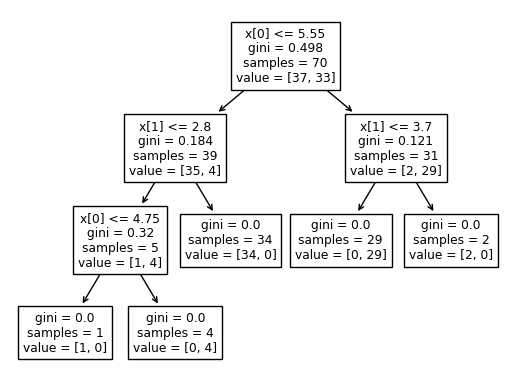

In [180]:
tree.plot_tree(clf) 

也可以导出树

In [181]:
tree_pic = export_graphviz(clf, out_file="mytree.pdf")
with open('mytree.pdf') as f:
    dot_graph = f.read()

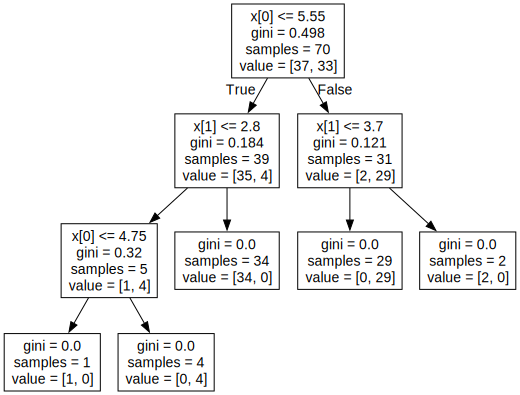

In [182]:
graphviz.Source(dot_graph)

或者，还可以使用函数 export_text以文本格式导出树。此方法不需要安装外部库，而且更紧凑：

In [183]:
from sklearn.tree import export_text

In [184]:
r = export_text(clf)

In [185]:
print(r)

|--- feature_0 <= 5.55
|   |--- feature_1 <= 2.80
|   |   |--- feature_0 <= 4.75
|   |   |   |--- class: 0.0
|   |   |--- feature_0 >  4.75
|   |   |   |--- class: 1.0
|   |--- feature_1 >  2.80
|   |   |--- class: 0.0
|--- feature_0 >  5.55
|   |--- feature_1 <= 3.70
|   |   |--- class: 1.0
|   |--- feature_1 >  3.70
|   |   |--- class: 0.0


### 决策树回归

In [186]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

In [187]:
# Create a random dataset
rng = np.random.RandomState(1)
X = np.sort(5 * rng.rand(80, 1), axis=0)
y = np.sin(X).ravel()
y[::5] += 3 * (0.5 - rng.rand(16))

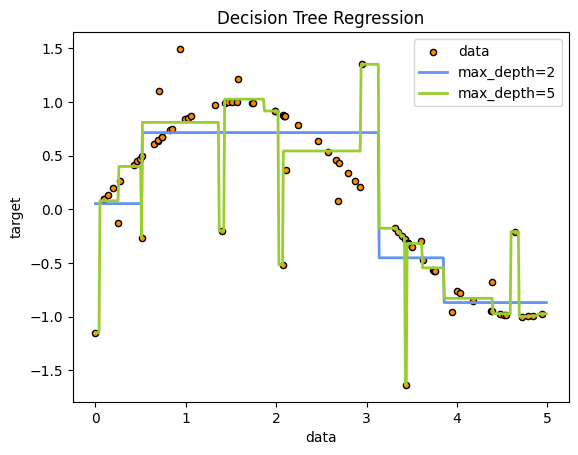

In [188]:
# Fit regression model
regr_1 = DecisionTreeRegressor(max_depth=2)
regr_2 = DecisionTreeRegressor(max_depth=5)
regr_1.fit(X, y)
regr_2.fit(X, y)

# Predict
X_test = np.arange(0.0, 5.0, 0.01)[:, np.newaxis]
y_1 = regr_1.predict(X_test)
y_2 = regr_2.predict(X_test)

# Plot the results
plt.figure()
plt.scatter(X, y, s=20, edgecolor="black", c="darkorange", label="data")
plt.plot(X_test, y_1, color="cornflowerblue", label="max_depth=2", linewidth=2)
plt.plot(X_test, y_2, color="yellowgreen", label="max_depth=5", linewidth=2)
plt.xlabel("data")
plt.ylabel("target")
plt.title("Decision Tree Regression")
plt.legend()
plt.show()

### Scikit-learn 的决策树参数

### 决策树调参

In [189]:
# 导入库
from sklearn.tree import DecisionTreeClassifier
from sklearn import datasets
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics

In [190]:
# 导入数据集
X = datasets.load_iris()  # 以全部字典形式返回,有data,target,target_names三个键
data = X.data
target = X.target
name = X.target_names
x, y = datasets.load_iris(return_X_y=True)  # 能一次性取前2个
print(x.shape, y.shape)

(150, 4) (150,)


In [191]:
# 数据分为训练集和测试集
x_train, x_test, y_train, y_test = train_test_split(x,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=100)

In [192]:
# 用GridSearchCV寻找最优参数（字典）
param = {
    'criterion': ['gini'],
    'max_depth': [30, 50, 60, 100],
    'min_samples_leaf': [2, 3, 5, 10],
    'min_impurity_decrease': [0.1, 0.2, 0.5]
}
grid = GridSearchCV(DecisionTreeClassifier(), param_grid=param, cv=6)
grid.fit(x_train, y_train)
print('最优分类器:', grid.best_params_, '最优分数:', grid.best_score_)  # 得到最优的参数和分值

最优分类器: {'criterion': 'gini', 'max_depth': 30, 'min_impurity_decrease': 0.1, 'min_samples_leaf': 3} 最优分数: 0.9416666666666665
